In [121]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Libraries for modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import time

In [122]:
# Reading the data file - FIATreeSpeciesCode_pft.csv
df_fia_species = pd.read_csv("./FIA/FIATreeSpeciesCode_pft.csv", sep=";")
df_fia_species_imp = df_fia_species[['SPCD', 'COMMON_NAME', 'PFT']].copy()

# Reading the data file - CA_TREE.csv
df_fia_tree = pd.read_csv("./FIA/CA_TREE.csv", low_memory=False)
df_fia_tree_imp = df_fia_tree[['STATECD', 'PLOT', 'PLT_CN', 'UNITCD', 'COUNTYCD', 'TREE', 'SPCD', 'DIA', 'HT', 'CR']].copy()

# Reading the data file - CA_PLOT.csv
df_fia_plot = pd.read_csv("./FIA/CA_PLOT.csv", low_memory=False)
df_fia_plot_imp = df_fia_plot[['PLOT_STATUS_CD', 'LAT', 'LON', 'ELEV', 'ECOSUBCD', 'CN']].copy()

# Create a dictionary mapping SPCD to COMMON_NAME
fia_ref_species_table = pd.read_csv('./FIA/REF_SPECIES.csv')
spcd_to_common_name = dict(zip(fia_ref_species_table['SPCD'], fia_ref_species_table['COMMON_NAME']))

# Analyzing the shape
print(df_fia_species_imp.shape)
print(df_fia_tree_imp.shape)
print(df_fia_plot_imp.shape)


(459, 3)
(427519, 10)
(42036, 6)


In [123]:
# Merging the FIA Species and FIA tree based on SPCD
df_fia = df_fia_tree_imp.merge(df_fia_species_imp, on="SPCD", how="left")
# Merging the resulting FIA dataset and FIA plot based on PLOT_CN and CN
df_fia = df_fia.merge(df_fia_plot_imp, left_on="PLT_CN", right_on="CN", how="left")
print(df_fia.shape)
df_fia.head()

(427519, 18)


,STATECD,PLOT,PLT_CN,UNITCD,COUNTYCD,TREE,SPCD,DIA,HT,CR,COMMON_NAME,PFT,PLOT_STATUS_CD,LAT,LON,ELEV,ECOSUBCD,CN
0,6,1,11839,1,15,675267,631.0,3.9,43.0,15.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839
1,6,1,11839,1,15,675268,202.0,24.1,95.0,45.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839
2,6,1,11839,1,15,675269,631.0,14.2,56.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839
3,6,1,11839,1,15,675270,631.0,10.5,52.0,35.0,tanoak,Deciduous,1,41.478172,-123.946777,1300.0,263Ab,11839
4,6,1,11839,1,15,675271,202.0,2.5,41.0,25.0,Douglas-fir,Evergreen conifer,1,41.478172,-123.946777,1300.0,263Ab,11839


In [124]:
# Analyzing the distribution of PFT
df_fia['PFT'].value_counts()

PFT
Evergreen conifer          279767
Evergreen broadleaf         57704
Deciduous broadleaf         49594
Deciduous                   33760
Evergreen                    6431
Flowering plants              230
Unknown                         6
Broadleaf                       4
Nitrogen fixing legumes         2
Deciduous confier               2
Name: count, dtype: int64

In [125]:
df_fia_ckpt1 = df_fia[['DIA', 'HT', 'LAT', 'LON', 'SPCD', 'ECOSUBCD', 'PFT']].copy()
df_fia_ckpt1.head()

,DIA,HT,LAT,LON,SPCD,ECOSUBCD,PFT
0,3.9,43.0,41.478172,-123.946777,631.0,263Ab,Deciduous
1,24.1,95.0,41.478172,-123.946777,202.0,263Ab,Evergreen conifer
2,14.2,56.0,41.478172,-123.946777,631.0,263Ab,Deciduous
3,10.5,52.0,41.478172,-123.946777,631.0,263Ab,Deciduous
4,2.5,41.0,41.478172,-123.946777,202.0,263Ab,Evergreen conifer


In [126]:
df_fia_ckpt1.isna().sum()

DIA         38452
HT          38451
LAT             0
LON             0
SPCD            0
ECOSUBCD        0
PFT            19
dtype: int64

In [127]:
df_fia_ckpt2 = df_fia_ckpt1.dropna(axis=0).copy()
print(df_fia_ckpt2.shape)
df_fia_ckpt2.head()

(389048, 7)


,DIA,HT,LAT,LON,SPCD,ECOSUBCD,PFT
0,3.9,43.0,41.478172,-123.946777,631.0,263Ab,Deciduous
1,24.1,95.0,41.478172,-123.946777,202.0,263Ab,Evergreen conifer
2,14.2,56.0,41.478172,-123.946777,631.0,263Ab,Deciduous
3,10.5,52.0,41.478172,-123.946777,631.0,263Ab,Deciduous
4,2.5,41.0,41.478172,-123.946777,202.0,263Ab,Evergreen conifer


In [128]:
# Converting from inches to cm
df_fia_ckpt2['DIA_cm'] = df_fia_ckpt2['DIA'] * 2.54
df_fia_ckpt2.head()

,DIA,HT,LAT,LON,SPCD,ECOSUBCD,PFT,DIA_cm
0,3.9,43.0,41.478172,-123.946777,631.0,263Ab,Deciduous,9.906
1,24.1,95.0,41.478172,-123.946777,202.0,263Ab,Evergreen conifer,61.214
2,14.2,56.0,41.478172,-123.946777,631.0,263Ab,Deciduous,36.068
3,10.5,52.0,41.478172,-123.946777,631.0,263Ab,Deciduous,26.670
4,2.5,41.0,41.478172,-123.946777,202.0,263Ab,Evergreen conifer,6.350


In [129]:
df_fia_ckpt2.isna().sum()

DIA         0
HT          0
LAT         0
LON         0
SPCD        0
ECOSUBCD    0
PFT         0
DIA_cm      0
dtype: int64

In [130]:
# Define the ECOSUBCDs to keep
ecosubcd_keep = ['M261Ep', '261Ba', 'M261Em', '263Am', 'M261Ej']

# Filter the DataFrame
df_fia_ckpt2_filtered = df_fia_ckpt2[df_fia_ckpt2['ECOSUBCD'].isin(ecosubcd_keep)]
# Shuffle the filtered DataFrame
df_fia_ckpt2_filtered_shuffled = df_fia_ckpt2_filtered.sample(frac=1, random_state=42).reset_index(drop=True)

df_fia_ecosubcd = df_fia_ckpt2_filtered_shuffled['ECOSUBCD']

# One hot encoding the categorical variable ECOSUBCD
df_encoded = pd.get_dummies(df_fia_ckpt2_filtered_shuffled, columns=['ECOSUBCD'])
df_encoded = df_encoded.drop(['ECOSUBCD_M261Ep'], axis=1)
df_encoded['ECOSUBCD'] = df_fia_ecosubcd
df_encoded.head()

,DIA,HT,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD
0,6.1,25.0,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,M261Ep
1,1.0,7.0,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,M261Em
2,16.8,66.0,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,M261Ep
3,17.2,49.0,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,M261Em
4,7.8,40.0,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,M261Ep


In [131]:
# # List of target columns
# columns = ['OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']

# # Sum of True values per column
# true_counts = df_encoded[columns].sum()

# # Total True values across all specified columns
# total_true = true_counts.sum()

# # Calculate distribution as percentage
# true_distribution = (true_counts / total_true * 100).round(2)

# print(true_distribution)

In [132]:
df_encoded.shape

(23726, 12)

In [133]:
replace_dict = {'Deciduous': 'Deciduous broadleaf'} 
df_encoded['PFT'] = df_encoded['PFT'].replace(replace_dict)
df_encoded = df_encoded[df_encoded['PFT'] != 'Broadleaf']
df_encoded['PFT'].value_counts()

PFT
Evergreen conifer      16936
Evergreen broadleaf     3476
Deciduous broadleaf     2872
Evergreen                425
Flowering plants          15
Name: count, dtype: int64

In [134]:
# # List of target columns
# occ_columns = ['OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']

# # Group by PFT and sum the True values in each OCC column
# pft_occ_true_counts = df_encoded.groupby('PFT')[occ_columns].sum()

# # Get total True counts per PFT (summing across all OCC columns)
# pft_total_true = pft_occ_true_counts.sum(axis=1)

# # Calculate distribution: OCC region as % of total True per PFT
# pft_occ_distribution = (pft_occ_true_counts.T / pft_total_true).T * 100
# pft_occ_distribution = pft_occ_distribution.round(2)

# pft_occ_distribution

In [135]:
df_encoded.groupby('ECOSUBCD')['PFT'].value_counts(normalize=True) * 100

ECOSUBCD  PFT                
261Ba     Evergreen broadleaf    98.969072
          Deciduous broadleaf     1.030928
263Am     Evergreen broadleaf    34.610778
          Evergreen conifer      24.431138
          Deciduous broadleaf    20.958084
          Evergreen              20.000000
M261Ej    Evergreen conifer      96.108742
          Deciduous broadleaf     3.837953
          Flowering plants        0.053305
M261Em    Evergreen conifer      82.695741
          Evergreen broadleaf     8.926294
          Deciduous broadleaf     8.365213
          Flowering plants        0.012752
M261Ep    Evergreen conifer      62.702124
          Evergreen broadleaf    19.540230
          Deciduous broadleaf    16.754335
          Evergreen               0.886421
          Flowering plants        0.116891
Name: proportion, dtype: float64

Class distribution in the dataset:
PFT
Evergreen conifer      0.713876
Evergreen broadleaf    0.146518
Deciduous broadleaf    0.121059
Evergreen              0.017914
Flowering plants       0.000632
Name: proportion, dtype: float64
Encoded classes: ['Deciduous broadleaf', 'Evergreen', 'Evergreen broadleaf', 'Evergreen conifer', 'Flowering plants']
Number of classes: 5
Original Training set size: 15420
Original Test set size: 8304
Final model training finished. Time: 1.80 seconds
------------------------------
Evaluating model on the test set...
Classification Report on Test Set:
                     precision    recall  f1-score   support

Deciduous broadleaf       0.63      0.52      0.57      1005
          Evergreen       0.60      0.54      0.57       149
Evergreen broadleaf       0.77      0.75      0.76      1217
  Evergreen conifer       0.91      0.94      0.93      5928
   Flowering plants       0.50      0.20      0.29         5

           accuracy                           

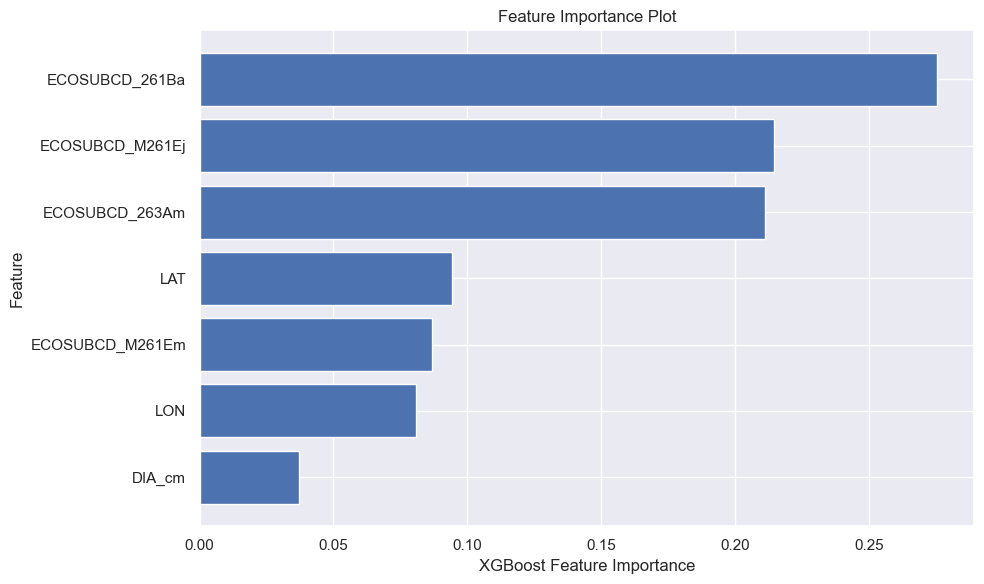

In [136]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

df_clean = df_encoded.copy()
independent_variables = ['DIA_cm', 'LAT', 'LON',
                         'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                         'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em']
dependent_variable = "PFT"
include_variables = independent_variables + [dependent_variable]

# Separate features (X) and target (y)
X = df_clean[independent_variables]
y = df_clean[dependent_variable]

# Check class distribution
print("Class distribution in the dataset:")
print(y.value_counts(normalize=True))

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print(f"Encoded classes: {list(le.classes_)}")
print(f"Number of classes: {num_classes}")

# Split into training and test sets (stratify to maintain class proportions)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.35, random_state=42, stratify=y_encoded
)

print(f"Original Training set size: {len(X_train)}")
print(f"Original Test set size: {len(X_test)}")

# Feature Scaling
numerical_cols = ['DIA_cm','LAT', 'LON'] # Adjust if you have others
categorical_cols = [col for col in independent_variables if col not in numerical_cols]

scaler = StandardScaler()

# Scale numerical features
# Fit on training data only, then transform train and test data
X_train_scaled_num = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled_num = scaler.transform(X_test[numerical_cols])

X_train_processed = np.hstack((X_train_scaled_num, X_train[categorical_cols].values))
X_test_processed = np.hstack((X_test_scaled_num, X_test[categorical_cols].values))

# Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_processed, y_train_encoded, test_size=0.30, random_state=42, stratify=y_train_encoded
)
start_time = time.time()

# {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
final_model = XGBClassifier(
    subsample=0.9,
    n_estimators=300,
    min_child_weight=1,
    max_depth=15,
    learning_rate=0.2,
    gamma=0.1,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=num_classes,       # Explicitly set number of classes
    eval_metric='mlogloss',
    random_state=42
)

# final_model = BernoulliNB()

# Use early stopping
eval_set = [(X_val, y_val)]
final_model.fit(
    X_train_final,
    y_train_final, # Stop if metric doesn't improve for 50 rounds
    # eval_set=eval_set,
    # verbose=False # Set to True to see training progress
)

print(f"Final model training finished. Time: {time.time() - start_time:.2f} seconds")
# print(f"Optimal number of trees found by early stopping: {final_model.best_ntree_limit}") # If early stopping was triggered
print("-" * 30)

# --- 5. Predict and Evaluate on the Test Set ---
print("Evaluating model on the test set...")

# Predict using the final model (either best_xgb_model or final_model if retrained)
predicted_pft_test_encoded = final_model.predict(X_test_processed)

# Decode predictions for readability
predicted_labels_decoded = le.inverse_transform(predicted_pft_test_encoded)

# Get original test labels for comparison
original_test_labels = le.inverse_transform(y_test_encoded)

# Classification report using original labels
report = classification_report(
    original_test_labels,
    predicted_labels_decoded,
    zero_division=0,
    target_names=le.classes_
)
print("Classification Report on Test Set:")
print(report)

# Overall accuracy
accuracy = accuracy_score(original_test_labels, predicted_labels_decoded)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("-" * 30)

# --- 6. Feature Importance ---
print("Plotting Feature Importance...")
try:
    # Create importance plot using feature names
    # Need to reconstruct feature names after hstack
    feature_names = numerical_cols + categorical_cols # Order matches hstack
    importance_scores = final_model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance_scores})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel("XGBoost Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance Plot")
    plt.gca().invert_yaxis() # Display most important features at the top
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")

### Working with TLS data

In [137]:
tls_treelist_df = pd.read_csv("./TLS/TLS_treelist.csv", index_col=0)
df_plot_identification = pd.read_csv("./TLS/blk_plot_identification.csv")
df_tls_data = tls_treelist_df.merge(df_plot_identification,on="plot_blk", how="left")
df_tls_data.head()

,TreeID,X,Y,Radius,Error,H,h_radius,DBH,BasalA,plot_blk,...,plot_num,inventory_date,inventory_hour,plot_coord_x,plot_coord_y,plot_coord_srs,plot_declination,inventory_plot_diam,plot_slopeper,plot_aspectdegre
0,1,10.673382,2.127033,0.266540,0.001199,12.560,1.3,20.987379,2.402324,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
1,6,2.429448,1.055521,0.166444,0.000730,8.742,1.3,13.105771,0.936786,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
2,8,2.149436,0.950025,0.759981,0.001151,13.469,1.3,59.840890,19.530404,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
3,9,1.962382,8.781092,0.267219,0.001217,18.144,1.3,21.040854,2.414582,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0
4,12,1.433234,0.234223,0.208154,0.000543,13.790,1.3,16.390056,1.465130,CAFKU_0101_20240802_1,...,101.0,8/2/24,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0


In [138]:
df_tls_data['site_name_label'].value_counts()

site_name_label
Calaveras Big Trees State Park    408
Independence Lake (IND)           229
Shaver Lake (SHA)                 209
Winton-Schaads VMP (WIN)          176
Pacific Union College (PUC)       176
Sedgwick Reserve (SDR)             88
Name: count, dtype: int64

In [139]:
from pyproj import Transformer
import pandas as pd

# Assuming your df is already loaded

# Create transformer from UTM Zone 11N (EPSG:26911) to WGS84 Lat/Lon (EPSG:4326)
transformer = Transformer.from_crs("EPSG:26911", "EPSG:4326", always_xy=True)

# Apply transformation to each row
df_tls_data[['LON', 'LAT']] = df_tls_data.apply(lambda row: pd.Series(transformer.transform(row['plot_coord_x'], row['plot_coord_y'])),
                              axis=1)

print(df_tls_data[['plot_coord_x', 'plot_coord_y', 'LON', 'LAT']].head())

   plot_coord_x  plot_coord_y         LON        LAT
0      298018.0     4108419.0 -119.272897  37.100323
1      298018.0     4108419.0 -119.272897  37.100323
2      298018.0     4108419.0 -119.272897  37.100323
3      298018.0     4108419.0 -119.272897  37.100323
4      298018.0     4108419.0 -119.272897  37.100323


In [140]:
# plt.figure(figsize=(8, 5))
# plt.hist(df_tls_data['LAT'], bins=20, edgecolor='black')
# plt.hist(df_encoded['LAT'], bins=20, edgecolor='red', alpha=0.5)
# plt.xlabel('LAT')
# plt.ylabel('Frequency')
# plt.title('Histogram of LAT')
# plt.tight_layout()
# plt.show()

In [141]:
# plt.figure(figsize=(8, 5))
# plt.hist(df_tls_data['LON'], bins=20, edgecolor='black')
# plt.hist(df_encoded['LON'], bins=20, edgecolor='red', alpha=0.5)
# plt.xlabel('LON')
# plt.ylabel('Frequency')
# plt.title('Histogram of LON')
# plt.tight_layout()
# plt.show()

In [142]:
df_tls_data.head()

,TreeID,X,Y,Radius,Error,H,h_radius,DBH,BasalA,plot_blk,...,inventory_hour,plot_coord_x,plot_coord_y,plot_coord_srs,plot_declination,inventory_plot_diam,plot_slopeper,plot_aspectdegre,LON,LAT
0,1,10.673382,2.127033,0.266540,0.001199,12.560,1.3,20.987379,2.402324,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,-119.272897,37.100323
1,6,2.429448,1.055521,0.166444,0.000730,8.742,1.3,13.105771,0.936786,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,-119.272897,37.100323
2,8,2.149436,0.950025,0.759981,0.001151,13.469,1.3,59.840890,19.530404,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,-119.272897,37.100323
3,9,1.962382,8.781092,0.267219,0.001217,18.144,1.3,21.040854,2.414582,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,-119.272897,37.100323
4,12,1.433234,0.234223,0.208154,0.000543,13.790,1.3,16.390056,1.465130,CAFKU_0101_20240802_1,...,9:20,298018.0,4108419.0,26911.0,12.28°E,11.3,25.0,89.0,-119.272897,37.100323


In [143]:
df_tls_data.columns

Index(['TreeID', 'X', 'Y', 'Radius', 'Error', 'H', 'h_radius', 'DBH', 'BasalA',
       'plot_blk', 'Unnamed: 0', 'inventory_id', 'site_project',
       'site_project_label', 'site_name', 'site_name_label',
       'inventory_pre_post_fire', 'inventory_pre_post_fire_label', 'plot_num',
       'inventory_date', 'inventory_hour', 'plot_coord_x', 'plot_coord_y',
       'plot_coord_srs', 'plot_declination', 'inventory_plot_diam',
       'plot_slopeper', 'plot_aspectdegre', 'LON', 'LAT'],
      dtype='object')

In [144]:
# Define your mapping
site_to_ecosubcd = {
    "Shaver Lake (SHA)": "M261Ep",
    "Sedgwick Reserve (SDR)": "261Ba",
    "Calaveras Big Trees State Park": "M261Em",
    "Pacific Union College (PUC)": "263Am",
    "Independence Lake (IND)": "M261Ej",
    "Winton-Schaads VMP (WIN)" :"M261Em",
}

# Create new column
df_tls_data['ECOSUBCD'] = df_tls_data['site_name_label'].map(site_to_ecosubcd)

print(df_tls_data[['site_name_label', 'ECOSUBCD', 'LAT', 'LON']].head())

     site_name_label ECOSUBCD        LAT         LON
0  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897
1  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897
2  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897
3  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897
4  Shaver Lake (SHA)   M261Ep  37.100323 -119.272897


In [145]:
df_tls_data['ECOSUBCD'].value_counts()

ECOSUBCD
M261Em    584
M261Ej    229
M261Ep    209
263Am     176
261Ba      88
Name: count, dtype: int64

In [146]:
df_tls_data = df_tls_data.dropna(axis=0).copy()

In [147]:
# def get_region_flags(lat, lon):
#     return pd.Series({
#         'OCC.NC_X': int(38 <= lat <= 42 and -124 <= lon <= -120),
#         'OCC.NE_X': int(42 < lat <= 49 and -120 < lon <= -104),  # Assuming NE means inland north
#         'OCC.PNW_X': int(42 < lat <= 49 and -125 <= lon <= -116),
#         'OCC.RM_X': int(37 <= lat <= 49 and -116 < lon <= -104),
#         'OCC.SO_X': int(32 <= lat < 38 and -124 <= lon <= -114),
#     })

# # Apply to your dataframe
# df_tls_data[['OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']] = df_tls_data.apply(
#     lambda row: get_region_flags(row['LAT'], row['LON']),
#     axis=1
# )

# print(df_tls_data[['LAT', 'LON', 'OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']].head())

In [148]:
TLS_X = df_tls_data[['DBH', 'H', 'LAT', 'LON', 'ECOSUBCD']].copy()

In [149]:
# match the feautre names 
TLS_X.columns = ['DIA_cm', 'HT', 'LAT', 'LON', 'ECOSUBCD']

In [150]:
# One hot encoding the categorical variable ECOSUBCD
TLS_X_ECOSUBCD = TLS_X['ECOSUBCD'].copy()
TLS_X = pd.get_dummies(TLS_X, columns=['ECOSUBCD'])
TLS_X = TLS_X.drop(['ECOSUBCD_M261Ep'], axis=1)
TLS_X = TLS_X[['DIA_cm','HT', 'LAT', 'LON',
                         'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                         'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em']]
TLS_X['ECOSUBCD'] = TLS_X_ECOSUBCD
# Shuffle the filtered DataFrame
TLS_X_shuffled = TLS_X.sample(frac=1, random_state=42).reset_index(drop=True)
TLS_X_shuffled = TLS_X.copy()
TLS_X_shuffled['LAT'] = TLS_X_shuffled['LAT'].fillna(TLS_X_shuffled['LAT'].mode())
TLS_X_shuffled['LON'] = TLS_X_shuffled['LON'].fillna(TLS_X_shuffled['LON'].mode())
TLS_X_shuffled.head()

,DIA_cm,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD
0,20.987379,12.560,37.100323,-119.272897,False,False,False,False,M261Ep
1,13.105771,8.742,37.100323,-119.272897,False,False,False,False,M261Ep
2,59.840890,13.469,37.100323,-119.272897,False,False,False,False,M261Ep
3,21.040854,18.144,37.100323,-119.272897,False,False,False,False,M261Ep
4,16.390056,13.790,37.100323,-119.272897,False,False,False,False,M261Ep


In [151]:
TLS_X_shuffled.shape

(1286, 9)

In [152]:
# Feature Scaling

independent_variables = ['DIA_cm','LAT', 'LON',
                         'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
                         'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em']

# "DIA_cm", 'HT', 'LAT', 'LON', "OCC.NC_X", "OCC.NE_X", "OCC.PNW_X", "OCC.RM_X",
#                          'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
#                          'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em'

numerical_cols = ['DIA_cm','LAT', 'LON'] # Adjust if you have others
categorical_cols = [col for col in independent_variables if col not in numerical_cols]

In [153]:
# Scale numerical features
# Fit on training data only, then transform train and test data
TLS_X_scaled = scaler.fit_transform(TLS_X_shuffled[numerical_cols])
print(len(TLS_X_scaled))
TLS_train_processed = np.hstack((TLS_X_scaled, TLS_X_shuffled[categorical_cols].values))
print(len(TLS_train_processed))
predicted_pft_tls = final_model.predict(TLS_train_processed)
print(len(predicted_pft_tls))
# X_test_scaled_num = scaler.transform(X_test[numerical_cols])

1286
1286
1286


In [154]:
# Decode predictions for readability
predicted_labels_TLS_decoded = le.inverse_transform(predicted_pft_tls)
len(predicted_labels_TLS_decoded)

1286

In [155]:
TLS_X['predicted_PFT'] = predicted_labels_TLS_decoded
TLS_X['predicted_PFT'].value_counts()

predicted_PFT
Evergreen conifer      891
Evergreen broadleaf    340
Deciduous broadleaf     55
Name: count, dtype: int64

In [156]:
# # List of target columns
# occ_columns = ['OCC.NC_X', 'OCC.NE_X', 'OCC.PNW_X', 'OCC.RM_X', 'OCC.SO_X']

# # Group by PFT and sum the True values in each OCC column
# pft_occ_true_counts = TLS_X.groupby('predicted_PFT')[occ_columns].sum()

# # Get total True counts per PFT (summing across all OCC columns)
# pft_total_true = pft_occ_true_counts.sum(axis=1)

# # Calculate distribution: OCC region as % of total True per PFT
# pft_occ_distribution = (pft_occ_true_counts.T / pft_total_true).T * 100
# pft_occ_distribution = pft_occ_distribution.round(2)

# pft_occ_distribution

In [157]:
# Calculate value counts as percentages
percentages = TLS_X['predicted_PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

predicted_PFT
Evergreen conifer      69.28
Evergreen broadleaf    26.44
Deciduous broadleaf     4.28
Name: proportion, dtype: float64


In [158]:
# Calculate value counts as percentages
percentages = TLS_X.groupby('ECOSUBCD')['predicted_PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

ECOSUBCD  predicted_PFT      
261Ba     Evergreen broadleaf     90.91
          Deciduous broadleaf      9.09
263Am     Evergreen conifer       77.27
          Deciduous broadleaf     22.73
M261Ej    Evergreen conifer      100.00
M261Em    Evergreen conifer       89.90
          Evergreen broadleaf      9.42
          Deciduous broadleaf      0.68
M261Ep    Evergreen broadleaf     98.09
          Deciduous broadleaf      1.44
          Evergreen conifer        0.48
Name: proportion, dtype: float64


### FIELD Data - GROUND Truth

In [159]:
df_field = pd.read_csv("./Field/03_tree.csv")
df_field_plot = pd.read_csv("./Field/01_plot_identification.csv")

print(df_field.shape)
print(df_field_plot.shape)

(2147, 22)
(163, 61)


In [160]:
df_field = df_field.merge(df_field_plot, on="inventory_id", how="left")
df_field.head()

,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,groundpost_cover_total,veg_cover_id,veg_cover_tot_veg_percent,veg_cover_tov_percent,veg_cover_und_percent,veg_cover_tos_percent,veg_cover_herb_percent,sp_invcov_id,sp_cov_inv_obs,sp_cov_inv_obs_label
0,143_pre_SHA_burn3d,1,204,ABCO,Abies concolor,NaN,Live,Live,8.2,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
1,143_pre_SHA_burn3d,2,205,ABCO,Abies concolor,NaN,Live,Live,54.6,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
2,143_pre_SHA_burn3d,3,206,ABCO,Abies concolor,NaN,Live,Live,86.9,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
3,143_pre_SHA_burn3d,4,207,ABCO,Abies concolor,NaN,Live,Live,21.7,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
4,143_pre_SHA_burn3d,5,208,ABCO,Abies concolor,NaN,Live,Live,45.3,NaN,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail


In [161]:
df_field.shape

(2147, 82)

In [162]:
df_field = df_field.merge(df_fia_species, left_on="tree_sp_scientific_name", right_on="SCI_NAME", how="left")
df_field.shape

(2147, 94)

In [163]:
# Calculate value counts as percentages
percentages = df_field['PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

PFT
Evergreen conifer      69.82
Evergreen broadleaf    21.43
Deciduous broadleaf     6.85
Deciduous               1.86
Tree                    0.05
Name: proportion, dtype: float64


In [164]:
# Define your mapping
site_to_ecosubcd = {
    "Shaver Lake (SHA)": "M261Ep",
    "Sedgwick Reserve (SDR)": "261Ba",
    "Calaveras Big Trees State Park": "M261Em",
    "Pacific Union College (PUC)": "263Am",
    "Independence Lake (IND)": "M261Ej",
    "Winton-Schaads VMP (WIN)" :"M261Em",
}

# Create new column
df_field['ECOSUBCD'] = df_field['site_name_label'].map(site_to_ecosubcd)
df_field['ECOSUBCD'].value_counts()

# print(df_field[['site_name_label', 'ECOSUBCD', 'LAT', 'LON']].head())

ECOSUBCD
M261Em    814
261Ba     364
M261Ej    358
M261Ep    348
263Am     263
Name: count, dtype: int64

In [165]:
# Calculate value counts as percentages
percentages = df_field.groupby('ECOSUBCD')['PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

ECOSUBCD  PFT                
261Ba     Evergreen broadleaf    84.07
          Deciduous broadleaf    15.93
263Am     Evergreen broadleaf    50.95
          Evergreen conifer      40.68
          Deciduous broadleaf     8.37
M261Ej    Evergreen conifer      93.58
          Deciduous               6.42
M261Em    Evergreen conifer      89.31
          Deciduous broadleaf     8.11
          Evergreen broadleaf     2.46
          Tree                    0.12
M261Ep    Evergreen conifer      94.83
          Deciduous               4.89
          Deciduous broadleaf     0.29
Name: proportion, dtype: float64


In [166]:
"""
ECOSUBCD  predicted_PFT      
261Ba     Evergreen broadleaf     84.09
          Deciduous broadleaf     15.91
263Am     Evergreen conifer       42.61
          Deciduous broadleaf     28.98
          Evergreen broadleaf     28.41
M261Ej    Evergreen conifer      100.00
M261Em    Evergreen conifer       88.53
          Evergreen broadleaf     11.47
M261Ep    Evergreen broadleaf     95.22
          Deciduous broadleaf      3.83
          Evergreen conifer        0.96
"""

'\nECOSUBCD  predicted_PFT      \n261Ba     Evergreen broadleaf     84.09\n          Deciduous broadleaf     15.91\n263Am     Evergreen conifer       42.61\n          Deciduous broadleaf     28.98\n          Evergreen broadleaf     28.41\nM261Ej    Evergreen conifer      100.00\nM261Em    Evergreen conifer       88.53\n          Evergreen broadleaf     11.47\nM261Ep    Evergreen broadleaf     95.22\n          Deciduous broadleaf      3.83\n          Evergreen conifer        0.96\n'

## GENUS

In [167]:
df_ref_species = pd.read_csv('./FIA/REF_SPECIES.csv')
df_ref_species = df_ref_species[['SPCD', 'GENUS', 'SPECIES', 'COMMON_NAME']].copy()
print(f"Shape: {df_ref_species.shape}")
df_ref_species.head()

Shape: (2677, 4)


,SPCD,GENUS,SPECIES,COMMON_NAME
0,6156.0,Araucaria,excelsa,Norfolk Island pine
1,6157.0,Araucaria,heterophylla,Norfolk Island pine
2,6158.0,Araucaria,spp.,Araucaria
3,6159.0,Archontophoenix,alexandrae,Alexandra palm
4,6160.0,Archontophoenix,cunninghamiana,Bangalow palm


In [168]:
df_encoded

,DIA,HT,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD
0,6.1,25.0,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,M261Ep
1,1.0,7.0,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,M261Em
2,16.8,66.0,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,M261Ep
3,17.2,49.0,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,M261Em
4,7.8,40.0,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,M261Ep
...,...,...,...,...,...,...,...,...,...,...,...,...
23721,17.6,57.0,38.001863,-120.030085,122.0,Evergreen conifer,44.704,False,False,False,True,M261Em
23722,7.2,28.0,36.211111,-118.657481,818.0,Deciduous broadleaf,18.288,False,False,False,False,M261Ep
23723,2.0,10.0,37.096947,-119.360283,81.0,Evergreen conifer,5.080,False,False,False,False,M261Ep
23724,6.0,20.0,35.565308,-118.647105,333.0,Deciduous broadleaf,15.240,False,False,False,False,M261Ep


In [169]:
df_encoded = df_encoded.merge(df_ref_species, on="SPCD", how="left")
print(f"Shape: {df_encoded.shape}")
df_encoded.head()

Shape: (23724, 15)


,DIA,HT,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,M261Em,Abies,concolor,white fir
2,16.8,66.0,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,M261Ep,Pinus,lambertiana,sugar pine


In [170]:
df_encoded['GENUS'].value_counts()

GENUS
Pinus             5981
Quercus           5489
Calocedrus        5072
Abies             5058
Pseudotsuga        654
Umbellularia       425
Arbutus            229
Aesculus           169
Cornus             125
Cercocarpus        118
Acer                76
Juniperus           68
Sequoia             57
Lithocarpus         57
Alnus               43
Sequoiadendron      34
Populus             30
Prunus              15
Torreya              6
Cupressus            6
Fraxinus             5
Platanus             4
Eucalyptus           3
Name: count, dtype: int64

In [171]:
df_encoded['PFT'] = df_encoded['PFT'].astype('category')
df_encoded.head()

,DIA,HT,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,M261Em,Abies,concolor,white fir
2,16.8,66.0,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,M261Ep,Pinus,lambertiana,sugar pine


In [172]:
df_encoded.columns

Index(['DIA', 'HT', 'LAT', 'LON', 'SPCD', 'PFT', 'DIA_cm', 'ECOSUBCD_261Ba',
       'ECOSUBCD_263Am', 'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'ECOSUBCD',
       'GENUS', 'SPECIES', 'COMMON_NAME'],
      dtype='object')

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# --- Prepare dataset -----------------------------------------------------------
include_vars = ['DIA_cm', 'HT','ECOSUBCD_261Ba','ECOSUBCD_263Am', 'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em',"PFT", "LAT", "LON", "ECOSUBCD", "GENUS"]

df = df_encoded[include_vars].dropna().copy()  

# Treat categorical columns properly
cat_cols = ["ECOSUBCD", "PFT"]
for col in cat_cols:
    df[col] = df[col].astype("category")

X = df.drop(columns=["GENUS","PFT"])
y = df["GENUS"]

# --- Train-test split -----------------------------------------------------------
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.35, random_state=42
)

# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

# --- Fit XGBoost ---------------------------------------------------------------
model = XGBClassifier(
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,
    objective="multi:softmax",   # Direct label output
    eval_metric="mlogloss",
    tree_method="hist",
    enable_categorical=True,
    use_label_encoder=False,     # Important for newer XGBoost versions
    random_state=42
)

model.fit(X_train, y_train)

# --- Evaluate -----------------------------------------------------------------
pred = model.predict(X_test)

# Ensure only present labels are shown
labels = unique_labels(y_test, pred)

# Generate classification report
report = classification_report(
    y_test,
    pred,
    labels=labels,
    target_names=le.inverse_transform(labels),
    zero_division=0,
)

print(report)

/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:00:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                precision    recall  f1-score   support

         Abies       0.76      0.73      0.74      1794
          Acer       0.52      0.61      0.56        23
      Aesculus       0.80      0.68      0.74        63
         Alnus       0.80      0.22      0.35        18
       Arbutus       0.60      0.39      0.47        90
    Calocedrus       0.71      0.75      0.73      1791
   Cercocarpus       0.89      0.95      0.92        42
        Cornus       0.57      0.83      0.68        30
     Cupressus       1.00      1.00      1.00         2
     Juniperus       0.73      0.36      0.48        22
   Lithocarpus       0.15      0.09      0.11        22
         Pinus       0.78      0.75      0.76      2049
       Populus       0.56      0.56      0.56         9
        Prunus       1.00      0.80      0.89         5
   Pseudotsuga       0.58      0.54      0.56       225
       Quercus       0.82      0.87      0.84      1944
       Sequoia       0.60      0.60      0.60  

In [174]:
X 

,DIA_cm,HT,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,LAT,LON,ECOSUBCD
0,15.494,25.0,False,False,False,False,37.514660,-119.737508,M261Ep
1,2.540,7.0,False,False,False,True,38.153364,-120.059054,M261Em
2,42.672,66.0,False,False,False,False,37.075657,-119.382396,M261Ep
3,43.688,49.0,False,False,False,True,38.605369,-120.371609,M261Em
4,19.812,40.0,False,False,False,False,37.370380,-119.540933,M261Ep
...,...,...,...,...,...,...,...,...,...
23719,44.704,57.0,False,False,False,True,38.001863,-120.030085,M261Em
23720,18.288,28.0,False,False,False,False,36.211111,-118.657481,M261Ep
23721,5.080,10.0,False,False,False,False,37.096947,-119.360283,M261Ep
23722,15.240,20.0,False,False,False,False,35.565308,-118.647105,M261Ep


In [175]:
y 

0        Calocedrus
1             Abies
2        Calocedrus
3        Calocedrus
4             Pinus
            ...    
23719         Pinus
23720       Quercus
23721    Calocedrus
23722      Aesculus
23723         Pinus
Name: GENUS, Length: 23724, dtype: object

In [176]:
model = XGBClassifier(
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,
    objective="multi:softmax",   # Direct label output
    eval_metric="mlogloss",
    tree_method="hist",
    enable_categorical=True,
    use_label_encoder=False,     # Important for newer XGBoost versions
    random_state=42
)

In [177]:
le_genus = LabelEncoder()
y = le_genus.fit_transform(y)
model.fit(X,y)

/Users/ironman/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:00:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [178]:
TLS_X

,DIA_cm,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,predicted_PFT
0,20.987379,12.560,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen broadleaf
1,13.105771,8.742,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen broadleaf
2,59.840890,13.469,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen conifer
3,21.040854,18.144,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen broadleaf
4,16.390056,13.790,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen broadleaf
...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,38.254746,-114.223306,False,False,False,True,M261Em,Evergreen conifer
1378,24.252048,23.077,38.254746,-114.223306,False,False,False,True,M261Em,Evergreen conifer
1379,17.835430,30.127,38.254746,-114.223306,False,False,False,True,M261Em,Evergreen conifer
1380,14.208700,29.300,38.254746,-114.223306,False,False,False,True,M261Em,Evergreen conifer


In [179]:
cat_cols = ["ECOSUBCD", "predicted_PFT"]
for col in cat_cols:
    TLS_X[col] = TLS_X[col].astype("category")

In [181]:
pred =  model.predict(TLS_X.drop(columns=["predicted_PFT"]))

ValueError: feature_names mismatch: ['DIA_cm', 'HT', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am', 'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'LAT', 'LON', 'ECOSUBCD'] ['DIA_cm', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am', 'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'ECOSUBCD']

In [182]:
# Use le_genus.inverse_transform(pred)
predicted_genus = le_genus.inverse_transform(pred)
# Add the predicted genus to the TLS_X DataFrame
TLS_X['predicted_genus'] = predicted_genus

ValueError: Length of values (8304) does not match length of index (1286)

In [183]:
TLS_X 

,DIA_cm,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,predicted_PFT
0,20.987379,12.560,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen broadleaf
1,13.105771,8.742,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen broadleaf
2,59.840890,13.469,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen conifer
3,21.040854,18.144,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen broadleaf
4,16.390056,13.790,37.100323,-119.272897,False,False,False,False,M261Ep,Evergreen broadleaf
...,...,...,...,...,...,...,...,...,...,...
1377,17.323968,30.631,38.254746,-114.223306,False,False,False,True,M261Em,Evergreen conifer
1378,24.252048,23.077,38.254746,-114.223306,False,False,False,True,M261Em,Evergreen conifer
1379,17.835430,30.127,38.254746,-114.223306,False,False,False,True,M261Em,Evergreen conifer
1380,14.208700,29.300,38.254746,-114.223306,False,False,False,True,M261Em,Evergreen conifer


In [184]:
TLS_X['predicted_genus'].value_counts()

KeyError: 'predicted_genus'

In [186]:
# find percentage of each predicted genus
predicted_genus_counts = TLS_X['predicted_genus'].value_counts(normalize=True) * 100
# Display the percentage of each predicted genus
print("Percentage of each predicted genus:")
print(predicted_genus_counts)


KeyError: 'predicted_genus'